In [119]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv2D
from tensorflow.keras.layers import GlobalAvgPool2D,LSTM,Dense,Dropout

In [120]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
path = "/content/drive/MyDrive/Video_Prediction/"
data = np.load(path + 'test.npy')

In [122]:
data.shape

(67, 15, 64, 64, 3)

In [123]:
# Define image dimensions and frames to be used for LSTM memory
sequence_length = 14 
image_height = data.shape[2]
image_width = data.shape[3]

In [ ]:
# swap frames and observations so [obs, frames, height, width, channels]
data = data.swapaxes(0, 1)

In [124]:
data.shape

(67, 15, 64, 64, 3)

In [62]:
data1 = np.expand_dims(data, 4)
data1.shape

(67, 15, 64, 64, 1, 3)

In [125]:
# only select first 100 observations to reduce memory- and compute requirements
sub = data[:60, :, :, :]
# add channel dimension (grayscale)
sub = np.expand_dims(sub, 4)

In [126]:
sub.shape

(60, 15, 64, 64, 3)

In [127]:
# normalize to 0, 1
sub = sub / 255
#sub[sub < 128] = 0
#sub[sub>= 128] = 1

In [128]:
# Define network

seq = Sequential()
seq.add(ConvLSTM2D(filters=64, kernel_size=(1,1),
                   input_shape=(None,image_height, image_width, 3), #Will need to change channels to 3 for real images
                   padding='same', return_sequences=True,
                   activation='relu'))
seq.add(BatchNormalization())
seq.add(ConvLSTM2D(filters=64, kernel_size=(2,2),
                   padding='same', return_sequences=True,
                   activation='relu'))
seq.add(BatchNormalization())
seq.add(ConvLSTM2D(filters=64, kernel_size=(1,1),
                   padding='same', return_sequences=True,
                   activation='relu'))
seq.add(BatchNormalization())
seq.add(ConvLSTM2D(filters=64, kernel_size=(2,2),
                   padding='same', return_sequences=True,
                   activation='relu'))
seq.add(BatchNormalization())
seq.add(Conv3D(filters=1, kernel_size=(1,1,1),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adam')


In [129]:
# Define network

seq1 = Sequential()
seq1.add(ConvLSTM2D(filters=64, kernel_size=(1,1),
                   input_shape=(None,image_height, image_width,3), #Will need to change channels to 3 for real images
                   padding='same', return_sequences=True,
                   activation='relu'))
seq1.add(BatchNormalization())
seq1.add(ConvLSTM2D(filters=64, kernel_size=(2,2),
                   padding='same', return_sequences=True,
                   activation='relu'))
seq1.add(BatchNormalization())
seq1.add(ConvLSTM2D(filters=64, kernel_size=(1,1),
                   padding='same', return_sequences=True,
                   activation='relu'))
seq1.add(BatchNormalization())
seq1.add(ConvLSTM2D(filters=64, kernel_size=(2,2),
                   padding='same', return_sequences=True,
                   activation='relu'))
seq1.add(BatchNormalization())
seq1.add(Conv3D(filters=3, kernel_size=(1,1,1),
               activation='softmax',
               padding='same', data_format='channels_last'))
seq1.compile(loss='categorical_crossentropy', optimizer='adam')

In [130]:
seq1.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_68 (ConvLSTM2D) (None, None, 64, 64, 64)  17408     
_________________________________________________________________
batch_normalization_68 (Batc (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_69 (ConvLSTM2D) (None, None, 64, 64, 64)  131328    
_________________________________________________________________
batch_normalization_69 (Batc (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_70 (ConvLSTM2D) (None, None, 64, 64, 64)  33024     
_________________________________________________________________
batch_normalization_70 (Batc (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_71 (ConvLSTM2D) (None, None, 64, 64, 64)

In [141]:
# Add helper function for shifting input and output, so previous frame (X_t-1) is used as input to predict next frame (y_t)

def shift_data(data, n_frames=15):
    X = data[:, 0:n_frames, :, :, :]
    y = data[:, 1:(n_frames+1), :, :, :]
    return X, y


In [142]:
# Run script

# prepare X, y
X, y = shift_data(sub, sequence_length)


In [143]:
print(X.shape)
print(y.shape)

(60, 14, 64, 64, 3)
(60, 14, 64, 64, 3)


In [144]:
# fit the model
seq1.fit(X, y, batch_size=10, epochs=100, validation_split=0.05)
#seq.fit(X, y, epochs=100)

Epoch 1/100
6/6 [==============================] - 3s 467ms/step - loss: 1.8821 - val_loss: 1.7669
Epoch 2/100
6/6 [==============================] - 3s 461ms/step - loss: 1.8810 - val_loss: 1.7660
Epoch 3/100
6/6 [==============================] - 3s 458ms/step - loss: 1.8808 - val_loss: 1.7993
Epoch 4/100
6/6 [==============================] - 3s 458ms/step - loss: 1.8803 - val_loss: 1.7414
Epoch 5/100
6/6 [==============================] - 3s 459ms/step - loss: 1.8817 - val_loss: 1.8306
Epoch 6/100
6/6 [==============================] - 3s 462ms/step - loss: 1.8830 - val_loss: 1.7762
Epoch 7/100
6/6 [==============================] - 3s 455ms/step - loss: 1.8828 - val_loss: 1.8234
Epoch 8/100
6/6 [==============================] - 3s 459ms/step - loss: 1.8811 - val_loss: 1.7637
Epoch 9/100
6/6 [==============================] - 3s 456ms/step - loss: 1.8820 - val_loss: 1.8573
Epoch 10/100
6/6 [==============================] - 3s 458ms/step - loss: 1.8811 - val_loss: 1.7330
Epoch 11/

In [150]:
# select a random observation
test_set = np.expand_dims(X[4, :, :, :, :], 0)
#test_set = X[0:1, :, :, :]

In [151]:
test_set.shape

(1, 14, 64, 64, 3)

In [152]:
predictions = seq.predict(test_set)

In [153]:
predictions.shape

(1, 14, 64, 64, 1)

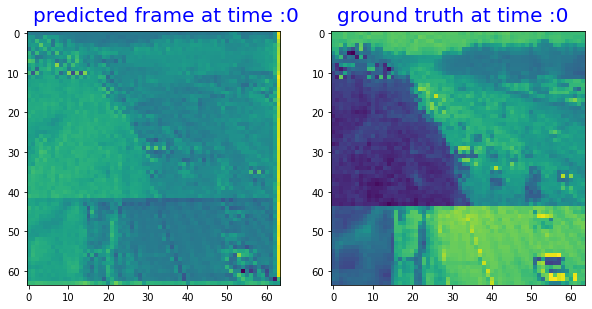

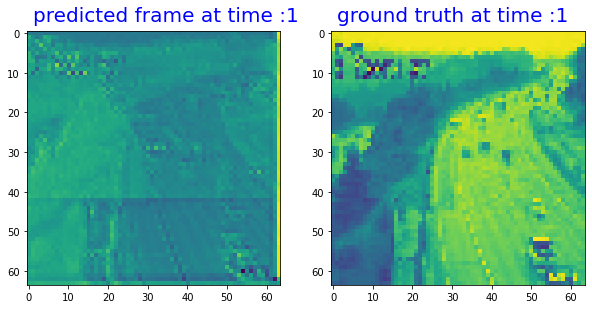

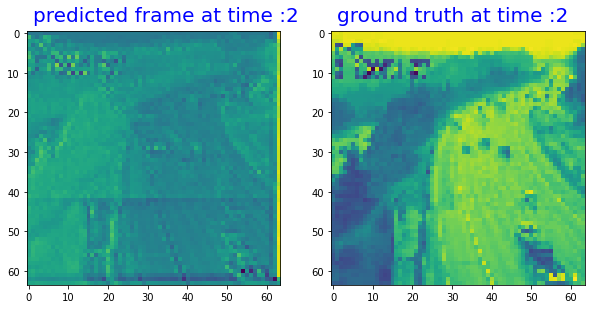

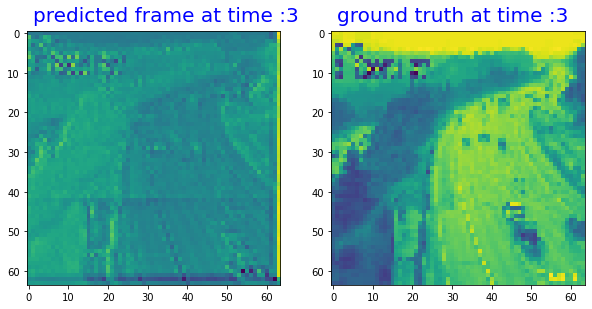

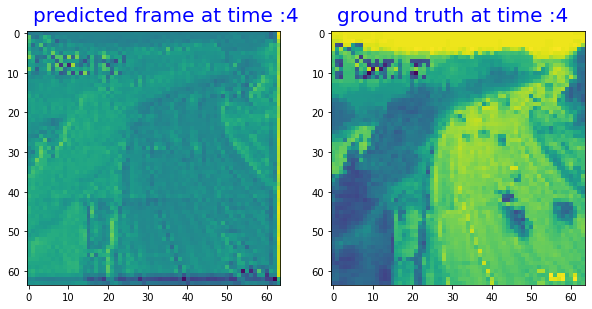

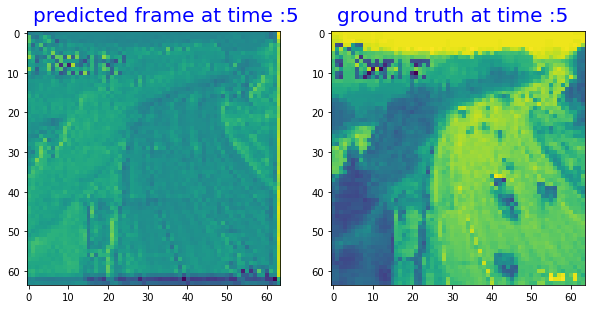

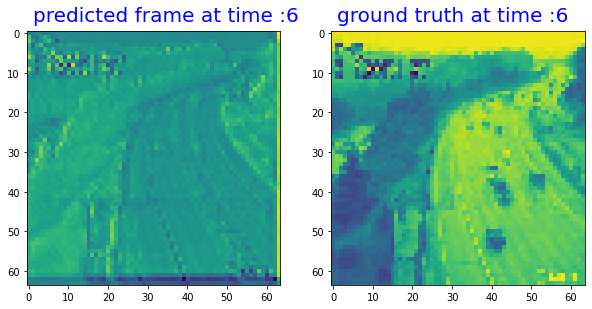

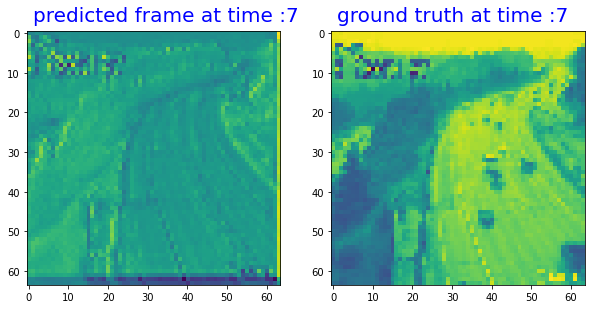

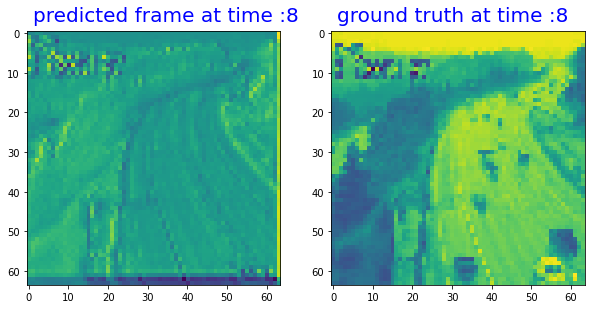

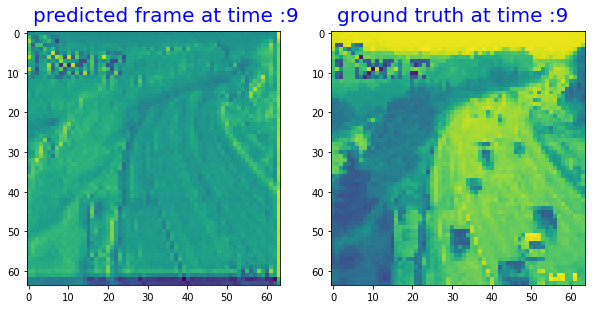

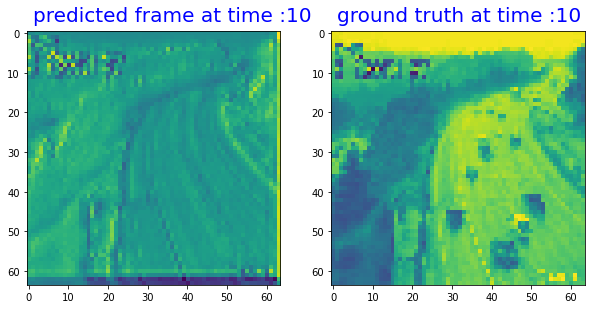

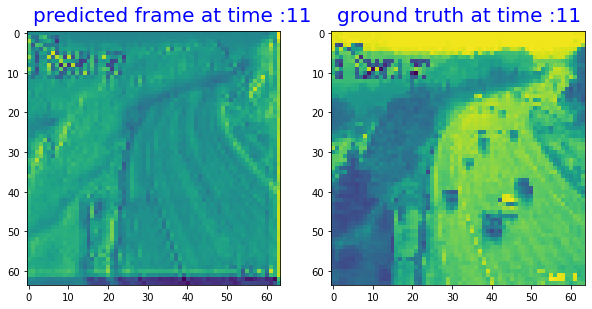

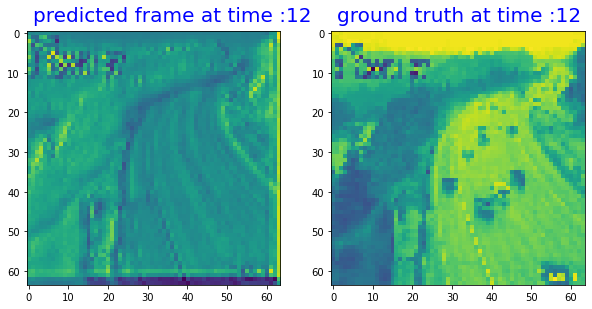

In [155]:
# compare to ground truth and visualize
for i in range(0, 13):
    # create plot
    fig = plt.figure(figsize=(10, 5))

    # truth
    ax = fig.add_subplot(122)
    ax.text(1, -3, ('ground truth at time :' + str(i)), fontsize=20, color='b')
    toplot_true = test_set[0, i, ::, ::, 0]
    plt.imshow(toplot_true)
    # predictions
    ax = fig.add_subplot(121)
    ax.text(1, -3, ('predicted frame at time :' + str(i)), fontsize=20, color='b')
    toplot_pred = predictions[0, i+1, ::, ::, 0]

    plt.imshow(toplot_pred)
    #plt.savefig(path + '/%i_image.png' % (i + 1))